In [158]:
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (18,12)
mpl.rcParams['axes.grid'] = False
sns.set_style('whitegrid')



In [159]:
data_frame = pd.read_csv('Data/jumps_input_data.csv', usecols=["Y","U"])
data_frame = data_frame[0:2000]
data_frame.shape


(2000, 2)

In [160]:
display(data_frame.head(10))

,Y,U
0,0.000000,-0.548246
1,0.000000,-0.548246
2,-0.554160,-0.548246
3,-0.548156,-0.548246
4,-0.005505,-0.548246
5,-0.530997,-0.548246
6,-0.533042,-0.548246
7,-0.032385,-0.548246
8,-0.510435,-0.548246
9,-0.506829,-0.548246


In [161]:
# Batch size
batch_size = 100

batch_data = np.array_split(data_frame, int(data_frame.shape[0]/batch_size))
df = pd.DataFrame(np.concatenate(batch_data),columns=list(data_frame.columns))


/opt/anaconda3/envs/rnn4nds/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


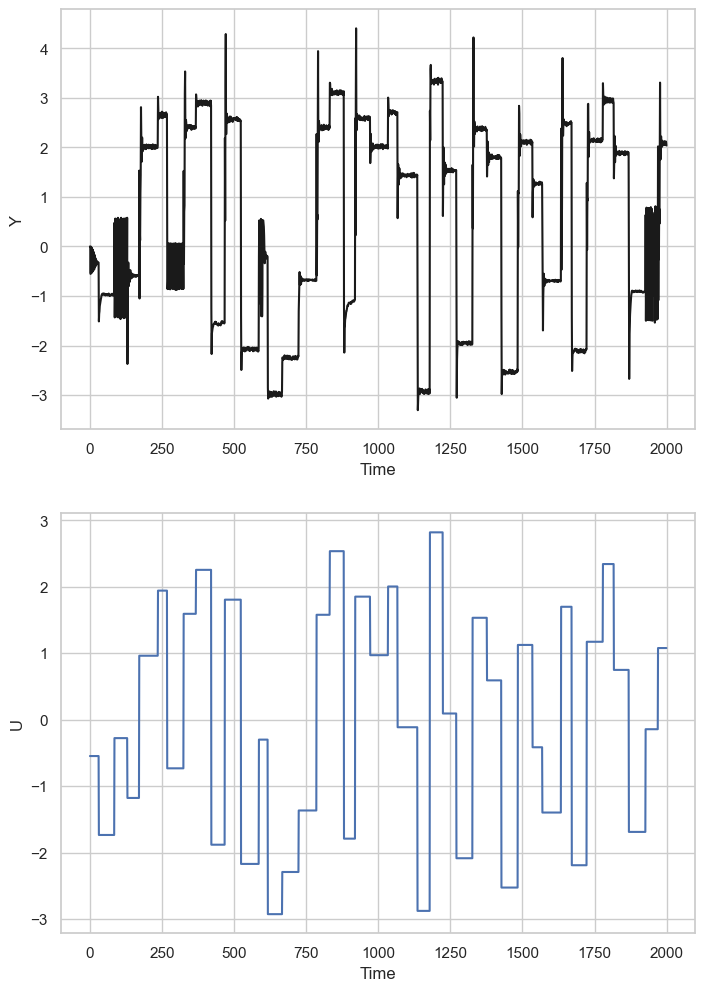

In [162]:
fig = plt.figure(figsize=(18,12))

batch_no_start = 1
batch_no_end = 20

plt.subplot(2, 2, 1)
plt.plot(data_frame[batch_size*(batch_no_start-1):batch_size*(batch_no_end)]['Y'],'k')
plt.xlabel('Time')
plt.ylabel('Y')

plt.subplot(2, 2, 3)
plt.plot(data_frame[batch_size*(batch_no_start-1):batch_size*(batch_no_end)]['U'],'b')
plt.xlabel('Time')
plt.ylabel('U')


plt.show()

In [163]:
ratio = 14 # how many samples from all of the data will be in training set
train_size = batch_size*ratio
dataset = df.values.astype(float)

scaler = MinMaxScaler((-1,1))

print(scaler.fit(dataset))
print("before scaling: max value: ",dataset.max(),"min value: ",dataset.min())
dataset = scaler.transform(dataset)
print("after scaling: max value: ",dataset.max(),"min value: ",dataset.min())

train_set = dataset[:train_size]
test_set = dataset[train_size:]

train_set = torch.FloatTensor(train_set).view(-1,df.shape[1])
test_set = torch.FloatTensor(test_set).view(-1,df.shape[1])

MinMaxScaler(feature_range=(-1, 1))
before scaling: max value:  4.404015400827661 min value:  -3.304820631148689
after scaling: max value:  1.0 min value:  -1.0


In [164]:
def input_data(seq,ws):
    inp_data = []
    for bat in range(0,train_set.shape[0],batch_size):
        
        bat_seq = seq[bat:bat+100]
        l = len(bat_seq)
        
        window = []
        label = []
        
        for i in range(l-ws):
        
            window = bat_seq[i:i+ws]
            label = bat_seq[i+ws:i+ws+1,:1]

            inp_data.append((window,label))
        
    return inp_data

In [165]:
# Defining a window size for prediction
window_size = 1
train_data = input_data(train_set,window_size)

print(train_data)

[(tensor([[-0.1426, -0.1718]]), tensor([[-0.1426]])), (tensor([[-0.1426, -0.1718]]), tensor([[-0.2864]])), (tensor([[-0.2864, -0.1718]]), tensor([[-0.2848]])), (tensor([[-0.2848, -0.1718]]), tensor([[-0.1440]])), (tensor([[-0.1440, -0.1718]]), tensor([[-0.2804]])), (tensor([[-0.2804, -0.1718]]), tensor([[-0.2809]])), (tensor([[-0.2809, -0.1718]]), tensor([[-0.1510]])), (tensor([[-0.1510, -0.1718]]), tensor([[-0.2750]])), (tensor([[-0.2750, -0.1718]]), tensor([[-0.2741]])), (tensor([[-0.2741, -0.1718]]), tensor([[-0.1595]])), (tensor([[-0.1595, -0.1718]]), tensor([[-0.2645]])), (tensor([[-0.2645, -0.1718]]), tensor([[-0.2677]])), (tensor([[-0.2677, -0.1718]]), tensor([[-0.1715]])), (tensor([[-0.1715, -0.1718]]), tensor([[-0.2506]])), (tensor([[-0.2506, -0.1718]]), tensor([[-0.2620]])), (tensor([[-0.2620, -0.1718]]), tensor([[-0.1866]])), (tensor([[-0.1866, -0.1718]]), tensor([[-0.2396]])), (tensor([[-0.2396, -0.1718]]), tensor([[-0.2494]])), (tensor([[-0.2494, -0.1718]]), tensor([[-0.20

In [166]:
from classy import LSTMModel

model = LSTMModel(2, 128, out_size=1, num_layers=4)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [167]:
display(model)

LSTMModel(
  (lstm_1): LSTM(2, 128, num_layers=4)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)

In [168]:
epochs = 100
batches = len(batch_data)*batch_size

average_loss = []
show_logs_every_batch = False
hidden=model.init_hidden(batch_size=1)

for epoch in range(epochs):
    
    # Running each batch separately 
    
    for bat in range(0,batches,batch_size):

        for seq,label in train_data[bat:bat+batch_size]:
            
            # set the optimization gradient to zero

            optimizer.zero_grad()
            # Make predictions on the current sequence

            y_pred = model(seq, hidden)  
            
            # Compute the loss

            loss = criterion(y_pred, label)
            average_loss.append(loss.item())
            # Perform back propogation and gradient descent
            loss.backward()

            optimizer.step()
        
        model.init_hidden(1)
        
        if (epoch+1)%10 == 0 and show_logs_every_batch:
            print(f'Epoch: {epoch+1}/{epochs}, batch: {bat+batch_size}/{batches}, Loss: {loss.item():10.8f}, Average Loss: {sum(average_loss)/len(average_loss)}')

                      


    if (epoch+1)%10 == 0 and not show_logs_every_batch:
        print(f'Epoch: {epoch+1}/{epochs} Loss: {loss.item():10.8f}, Average Loss: {sum(average_loss)/len(average_loss)}')

learnt_hidden=hidden

Epoch: 10/100 Loss: 0.00030767, Average Loss: 0.026505823107218007
Epoch: 20/100 Loss: 0.00011824, Average Loss: 0.02317099364323743
Epoch: 30/100 Loss: 0.00006916, Average Loss: 0.021316405716561168
Epoch: 40/100 Loss: 0.00006052, Average Loss: 0.02022428556243226
Epoch: 50/100 Loss: 0.00009172, Average Loss: 0.019532536391729527
Epoch: 60/100 Loss: 0.00004392, Average Loss: 0.019056772997736584
Epoch: 70/100 Loss: 0.00010980, Average Loss: 0.01868039453079648
Epoch: 80/100 Loss: 0.00005113, Average Loss: 0.018324496295754784
Epoch: 90/100 Loss: 0.00002129, Average Loss: 0.017997031330156097
Epoch: 100/100 Loss: 0.00015020, Average Loss: 0.017644670155697487


In [178]:
future = 600

model.eval()
preds = [test_set[0,:1].reshape(-1,1)]

for i in range(future-1):
    seq = test_set[i].reshape(-1,2)
    with torch.no_grad():
        pred = model(seq, hidden)
        preds.append(pred)

        
print(len(preds))       

600


In [179]:
predictions = np.array([pred.numpy() for pred in preds]).reshape(-1,1)
true_values = np.array(test_set[:,:1])

Text(0, 0.5, 'x1')

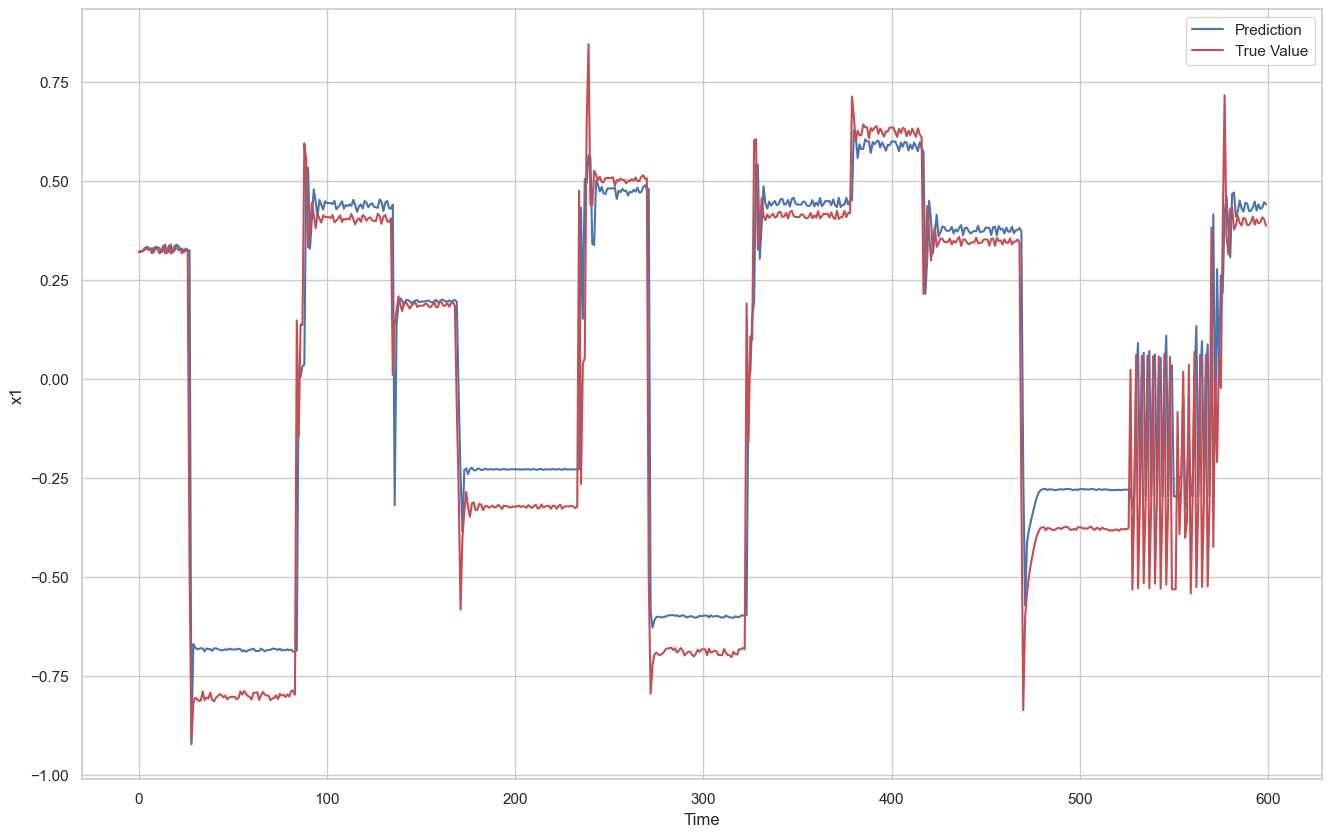

In [180]:
fig = plt.figure(figsize=(16,10))

plt.plot(predictions[:future,0],'b',label='Prediction')
plt.plot(true_values[:future,0],'r',label='True Value')
plt.legend()
plt.xlabel('Time')
plt.ylabel('x1')

In [233]:
rmse = np.sqrt(np.sum(np.square((predictions - true_values[:future])))/predictions.size)
display(rmse)

0.1564035093897523

In [187]:
future = 600
hidden = learnt_hidden
preds = [test_set[0,:1].reshape(-1,1)]
prediction_start = 1

for i in range(future-1):
    if i < prediction_start:
        seq = test_set[i].reshape(-1, 2)
    else:
        x = torch.FloatTensor(preds[-1])  # Assuming preds[-1] contains the last prediction
        y = test_set[i][1]
        seq = torch.FloatTensor([x, y]).view(-1, df.shape[1])
    # Check if the sequence length is greater than 0
    if seq.size(0) > 0:
        with torch.no_grad():
            pred = model(seq, hidden)
            preds.append(pred)

In [188]:
predictions2 = np.array([pred.numpy() for pred in preds]).reshape(-1,1)
true_values = np.array(test_set[:,:1])

Text(0, 0.5, 'x1')

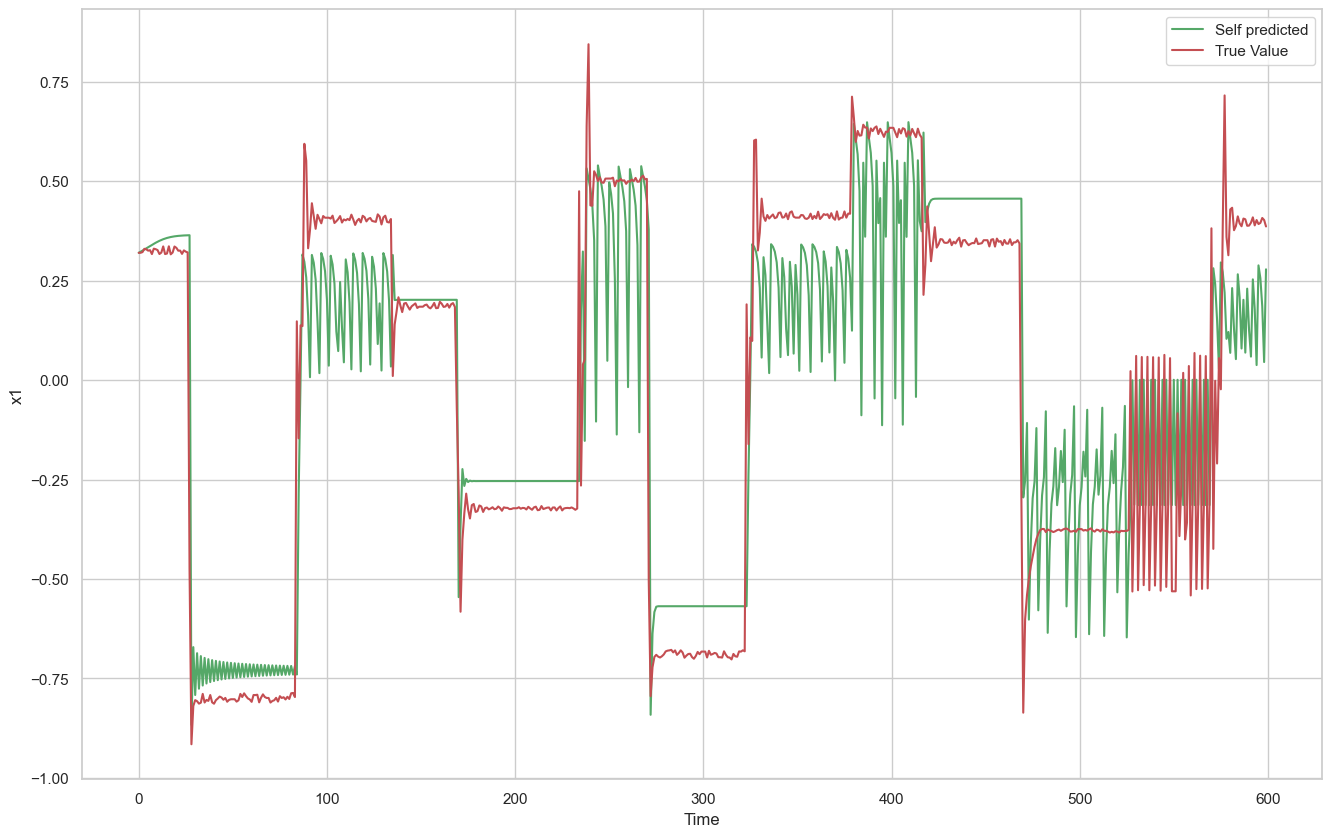

In [189]:
fig = plt.figure(figsize=(16,10))
plt.plot(predictions2[:future,0],'g',label='Self predicted')
# plt.plot(predictions[:future,0],'b',label='Prediction')
plt.plot(true_values[:future,0],'r',label='True Value')
plt.legend()
plt.xlabel('Time')
plt.ylabel('x1')

In [232]:
rmse = np.sqrt(np.sum(np.square((predictions2 - true_values[:future])))/predictions.size)
display(rmse)

0.20967366187591702

In [200]:
test_set

tensor([[0.3201, 0.2246],
        [0.3201, 0.2246],
        [0.3218, 0.2246],
        ...,
        [0.4076, 0.3940],
        [0.4025, 0.3940],
        [0.3863, 0.3940]])

In [224]:
first_sample = test_set[:1]
remaining_samples = test_set[:-1]
is_like_sample_before = torch.cat((first_sample,remaining_samples),0)

tensor([[0.3201, 0.2246]])
tensor([[0.3201, 0.2246],
        [0.3201, 0.2246],
        [0.3218, 0.2246],
        ...,
        [0.3952, 0.3940],
        [0.4076, 0.3940],
        [0.4025, 0.3940]])
tensor([[0.3201, 0.2246],
        [0.3201, 0.2246],
        [0.3201, 0.2246],
        ...,
        [0.3952, 0.3940],
        [0.4076, 0.3940],
        [0.4025, 0.3940]])


### Porównanie - wykresy

Text(0, 0.5, 'x1')

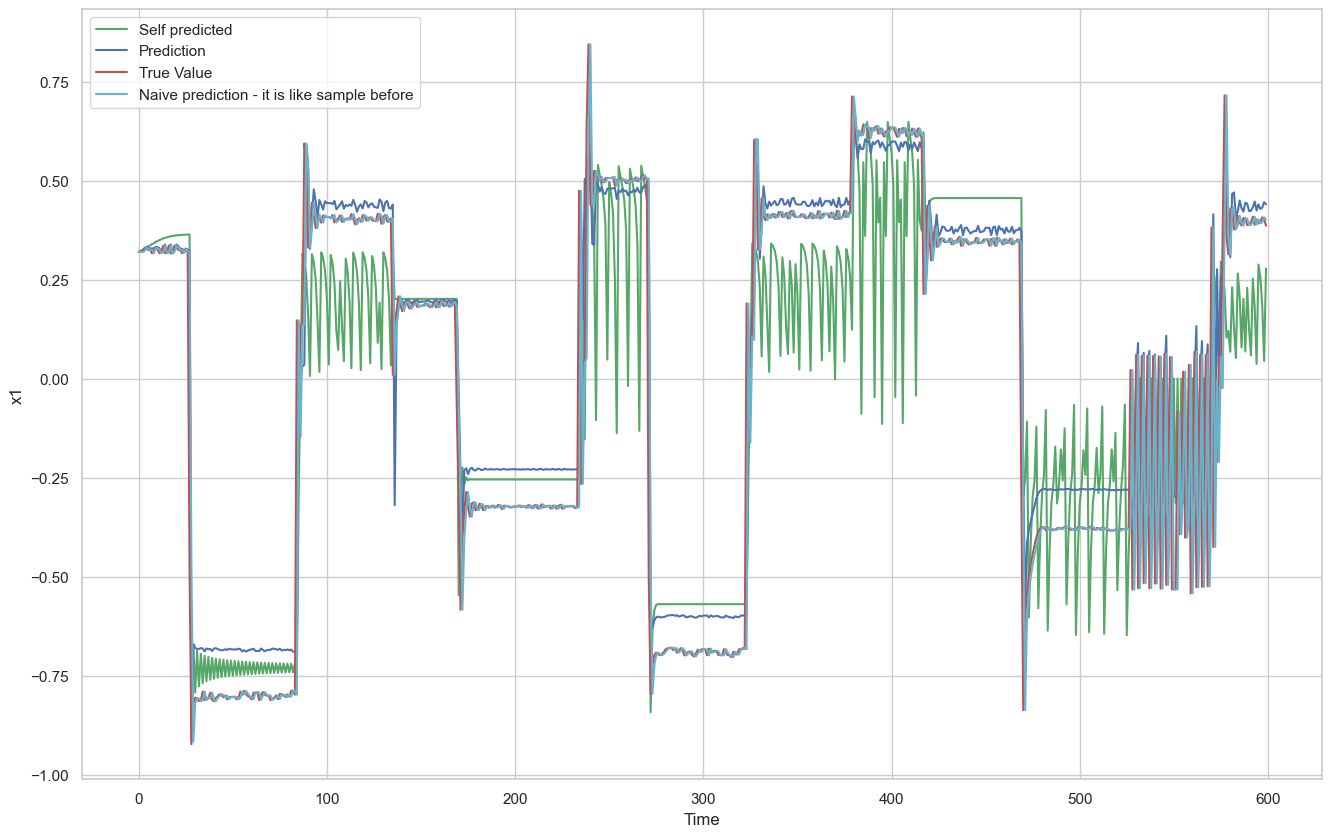

In [228]:
fig = plt.figure(figsize=(16,10))
plt.plot(predictions2[:future,0],'g',label='Self predicted')
plt.plot(predictions[:future,0],'b',label='Prediction')
plt.plot(true_values[:future,0],'r',label='True Value')
plt.plot(is_like_sample_before[:future,0],'c',label='Naive prediction - it is like sample before')
plt.legend()
plt.xlabel('Time')
plt.ylabel('x1')

### Porównanie RMSE

#### Przewidywanie naiwne

In [266]:
predictions3 = np.array(is_like_sample_before[:future,0].reshape(-1,1))
rmse = np.sqrt(np.sum(np.square((predictions3 - true_values[:future])))/predictions.size)
print(f"przewidywanie naiwne, rmse: {rmse:.4}")

przewidywanie naiwne rmse: 0.1663


##### Przewidywanie próbki w przód

In [272]:
rmse = np.sqrt(np.sum(np.square((predictions - true_values[:future])))/predictions.size)
print(f"przewidywanie próbki w przód przy pomocy sieci lstm, rmse: {rmse:.4}")

przewidywanie próbki w przód przy pomocy sieci lstm, rmse: 0.1564


##### Test zastąpienia systemu - sieć nie jest karmiona danymi z rzeczywistego systemu

In [273]:
rmse = np.sqrt(np.sum(np.square((predictions2 - true_values[:future])))/predictions.size)
print(f"przewidywanie dla {future} próbek przy pomocy sieci lstm, rmse: {rmse:.4}")

przewidywanie dla 600 próbek przy pomocy sieci lstm, rmse: 0.2097


### Wnioski
